# Ejercicio 7 - Hamiltoniano alias el diablo

La idea era ajustar datos a un modelo cuadrático usando monte carlo hamiltoniano. Traté de explicar la solución de jaime pero unas partes continuan siendo un misterio para mi.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Las primeras tres funciones son las mismas que siemrpe definimos para hacer MCMC.
#La única diferencia es que esta vez el man coge como prior una gaussiana porque ajá.
def model(x,param):
    """Modelo polinomial. `param` contiene los coeficientes.
    """
    n_param = len(param)
    y = 0
    for i in range(n_param):
        y += param[i] * x**i
    return y 
    
def loglikelihood(x_obs, y_obs, sigma_y_obs, param):
    """Logaritmo natural de la verosimilitud construida con los datos observacionales y los 
        parametros que describen el modelo.
    """
    d = y_obs -  model(x_obs, param)
    d = d/sigma_y_obs
    d = -0.5 * np.sum(d**2)
    return d

def logprior(param):
    """Logaritmo natural de los prior para los parametros.
        Todos corresponden a gaussianas con sigma=10.0.
    """
    d = -0.5 * np.sum(param**2/(10.0)**2)
    return d

Asumiendo que $F(\vec{q})$ es la likelihood y teniendo en mente que $\vec{q} = param$ y $\vec{p}$ será el vector con los momentos asociados, queremos resolver las ecuaciones de Hamilton para el siguiente hamiltoniano:

$$
\mathcal{H} = \frac{\vec{p}^2}{2m} -  \log (F(\vec{q})) 
$$

Las ecuaciones de hamilton son (componente a componente):

$$
\frac{\partial p}{\partial t} = -\frac{\partial \mathcal{H}}{\partial q}
$$os

$$
\frac{\partial q}{\partial t} = +\frac{\partial \mathcal{H}}{\partial p}
$$

Para resolverlas numericamente usamos las siguientes ecuaciones:

$$
p_{n+1} = p_{n} -\frac{\partial\mathcal{H}}{\partial q}\Delta t,
$$

$$
q_{n+1} = q_{n} + \frac{\partial \mathcal{H}}{\partial p}\Delta t.
$$

La primera ecuacion recibe el nombre de **kick** (es como un golpe que cambia el momentum) y la segunda ecuacion el de **drift** (es como un movimiento libre a velocidad constante).

In [3]:
#Esta función devuelve el valor de la derivada de log(F(param)) en param, calculado numericamente.
#Como depende de varias variables la derivada es en realidad una divergencia (se suman los valores
#de las derivadas parciales).
def divergence_loglikelihood(x_obs, y_obs, sigma_y_obs, param):
    """Divergencia del logaritmo de la funcion de verosimilitud.
    """
    n_param = len(param)
    div = np.ones(n_param)
    delta = 1E-5
    for i in range(n_param):
        delta_parameter = np.zeros(n_param)
        delta_parameter[i] = delta
        #Se suma y se resta delta_parameter para que justamente sea el valor de la derivada en param.
        div[i] = loglikelihood(x_obs, y_obs, sigma_y_obs, param + delta_parameter) 
        div[i] = div[i] - loglikelihood(x_obs, y_obs, sigma_y_obs, param - delta_parameter)
        div[i] = div[i]/(2.0 * delta)
    return div

def hamiltonian(x_obs, y_obs, sigma_y_obs, param, param_momentum):
    """Hamiltoniano: energia cinetica + potencial: K+V
    """
    m = 100.0 #Para mi la mayor incógnita. La masa es 100 porque ajá. Si le ponen 10 el fit es horrible.
    K = 0.5 * np.sum(param_momentum**2)/m
    V = -loglikelihood(x_obs, y_obs, sigma_y_obs, param)     
    return K + V

#Esto es la implementación de las ecuaciones kick y drift
def leapfrog_proposal(x_obs, y_obs, sigma_y_obs, param, param_momentum):
    """Integracion tipo leapfrog. 
        `param` representa las posiciones (i.e. los parametros).
        `param_momemtum` representa el momentum asociado a los parametros.
    """
    N_steps = 5 #Otro misterio, no sé porque hace 5 pasos.
    delta_t = 1E-2
    m = 100.0
    new_param = param.copy()
    new_param_momentum = param_momentum.copy()
    for i in range(N_steps):
        #Noten que el + es porque la formula es -logF(q)
        new_param_momentum = new_param_momentum + divergence_loglikelihood(x_obs, y_obs, sigma_y_obs, param) * 0.5 * delta_t 
        new_param = new_param + (new_param_momentum/m) * delta_t
        new_param_momentum = new_param_momentum + divergence_loglikelihood(x_obs, y_obs, sigma_y_obs, param) * 0.5 * delta_t
    new_param_momentum = -new_param_momentum #Misterio.
    return new_param, new_param_momentum


def monte_carlo(x_obs, y_obs, sigma_y_obs, N=5000):
    param = [np.random.random(3)]
    param_momentum = [np.random.normal(size=3)]
    for i in range(1,N):
        propuesta_param, propuesta_param_momentum = leapfrog_proposal(x_obs, y_obs, sigma_y_obs, param[i-1], param_momentum[i-1])
        energy_new = hamiltonian(x_obs, y_obs, sigma_y_obs, propuesta_param, propuesta_param_momentum)
        energy_old = hamiltonian(x_obs, y_obs, sigma_y_obs, param[i-1], param_momentum[i-1])
        #En este caso el criterio se hace con la energía.
        r = min(1,np.exp(-(energy_new - energy_old)))
        alpha = np.random.random()
        if(alpha<r):
            param.append(propuesta_param)
        else:
            param.append(param[i-1])
        param_momentum.append(np.random.normal(size=3))    

    param = np.array(param)
    return param
#Al final param es una matriz donde diferentes columnas corresponden a coeficientes diferentes.

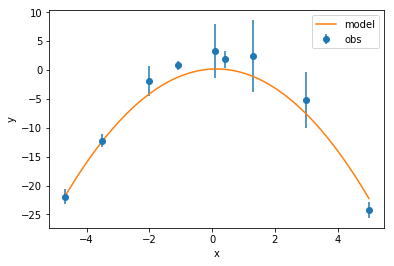

In [4]:
x_obs = np.array([-2.0,1.3,0.4,5.0,0.1, -4.7, 3.0, -3.5,-1.1])
y_obs = np.array([ -1.931,   2.38,   1.88,  -24.22,   3.31, -21.9,  -5.18, -12.23,   0.822])
sigma_y_obs = ([ 2.63,  6.23, -1.461, 1.376, -4.72,  1.313, -4.886, -1.091,  0.8054])

param_chain = monte_carlo(x_obs, y_obs, sigma_y_obs)
n_param  = len(param_chain[0])
best = []
for i in range(n_param):
    best.append(np.mean(param_chain[:,i]))


x_model = np.linspace(x_obs.min(), x_obs.max(), 100)
y_model = model(x_model, best)

plt.errorbar(x_obs,y_obs, yerr=sigma_y_obs, fmt='o', label='obs')
plt.plot(x_model, y_model, label='model')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()